# Description of the project

It is necessary to prepare a prototype of a machine learning model for the Zifry company.
<br> The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold ore.
<br> Data with extraction and treatment parameters are available.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

Necessary:

- Prepare data;
- Conduct exploratory data analysis;
- Build and train the model.

Gold from ore is obtained in the following way:

When the mined ore undergoes primary processing, a crushed mixture is obtained.
<br> It is sent for `flotation (enrichment)` and `two-stage cleaning`:

1. Flotation
A mixture of gold-bearing ore is fed into the flotation plant. After enrichment, a rough concentrate and “dump tails” are obtained, that is, product residues with a low concentration of valuable metals.
The stability of this process is affected by the unstable and non-optimal physical and chemical state of the flotation pulp (a mixture of solid particles and liquid).
2. Cleaning
The crude concentrate goes through two purifications. The output is the final concentrate and new final tailings.

You need to predict two quantities at once:
- rough concentrate enrichment efficiency `rougher.output.recovery`;
- efficiency of enrichment of the final concentrate `final.output.recovery`.

# Description of data

The data is in three files:

- gold_recovery_train.csv - train sample;
- gold_recovery_test.csv - test sample;
- gold_recovery_full.csv - initial data.

The data is indexed by the date and time the information was received (the date attribute). Parameters adjacent in time are often similar.

Some parameters are not available because they are measured and/or calculated much later. Because of this, the test set lacks some features that may be in the train set. Also, there are no target features in the test set.

The initial dataset contains the train and test sets with all features.

This is raw data: it has just been unloaded from storage. Before proceeding with the construction of the model, it is necessary to check them for correctness.


Technological process:
- Rougher feed - feedstock
- Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate ** - xanthate (promoter, or flotation activator);
- Sulphate - sulfate (in this production, sodium sulfide);
- Depressant - depressant (sodium silicate).
- Rougher process (English "rough process") - flotation
- Rougher tails
- Float banks - flotation unit
- Cleaner process - cleaning
- Rougher Au - rough gold concentrate
- Final Au - final gold concentrate

Stage parameters
- air amount — air volume
- fluid levels - fluid level
- feed size - feed granule size
- feed rate - feed rate


The name of the features is: `[stage].[parameter_type].[parameter_name]`
Example: `rougher.input.feed_ag`

Possible values ​​for the `[stage]` block:
- rougher - flotation
- primary_cleaner - primary cleaning
- secondary_cleaner - secondary cleaning
- final - final characteristics

Possible values ​​for the `[parameter_type]` block:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation - calculated characteristics

# Action plan

1. Prepare data
- 1.1. Open files and examine them.
- 1.2. Verify that the enrichment efficiency is calculated correctly. Calculate it on the train sample for the feature `rougher.output.recovery`. Find `MAE` between calculation and feature value. Describe findings.
- 1.3. Analyze features that are not available in the test sample. What are these parameters? What type are they?
- 1.4. Perform data preprocessing.
2. Analyze the data
- 2.1. See how the concentration of metals (Au, Ag, Pb) changes at different stages of purification. Describe findings.
- 2.2. Compare the size distributions of raw material granules on the train and test samples. If the distributions are very different from each other, the estimation of the model will be wrong.
- 2.3. Investigate the total concentration of all substances at different stages: in raw materials, in roughing and final concentrates. Are there any anomalous values ​​in the total distribution or not? If they are, should they be removed from both samples? Describe findings and remove anomalies.
3. Build the model
- 3.1. Write a function to calculate the final `sMAPE`.
- 3.2. Train different models and evaluate their quality by cross-validation. Choose the best model and test it on a test set. Describe findings.

# Data preparation

## Import data files, study general information

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from IPython.display import display
from IPython.display import display_html


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from scipy import stats as st

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [9]:
df_train = pd.read_csv('datasets/gold_recovery_train.csv', sep=',')
df_test = pd.read_csv('datasets/gold_recovery_test.csv', sep=',')
df_full = pd.read_csv('datasets/gold_recovery_full.csv', sep=',')

# df_train = pd.read_csv('/datasets/gold_recovery_train.csv', sep=',')
# df_test = pd.read_csv('/datasets/gold_recovery_test.csv', sep=',')
# df_full = pd.read_csv('/datasets/gold_recovery_full.csv', sep=',')

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [12]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [13]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

#display_side_by_side(df_train.head(),df_test.head(),df_full.head())

## Verification of enrichment efficiency calculation

Function for calculating enrichment efficiency

In [14]:
def recovery(df):
    
    """
    C — share of gold in concentrate after flotation/refining;
    F — share of gold in raw material/concentrate before flotation/refining;
    T — share of gold in final tailings after flotation/cleaning.
    """
    C = df['rougher.output.concentrate_au']
    F = df['rougher.input.feed_au']
    T = df['rougher.output.tail_au']
    
    return 100 * C * (F - T) / (F * (C - T))

Let's calculate the enrichment efficiency

In [15]:
not_my = df_train['rougher.output.recovery']
my = recovery(df_train)

Let's check if there are missing or infinite values in the received samples

In [16]:
print(np.any(np.isnan(not_my)))
print(np.all(np.isfinite(not_my)))
print()
print(np.any(np.isnan(my)))
print(np.all(np.isfinite(my)))

True
False

True
False


Let's create a new dataframe, in which we will enter two arrays so that we can correctly remove the gap

In [17]:
table = pd.DataFrame()
table['not_my'] = not_my
table['my'] = my
table = table.dropna()

In [18]:
print(np.any(np.isnan(table)))
print(np.all(np.isfinite(table)))

False
True


Calculate MAE

In [19]:
MAE = mean_absolute_error(table['not_my'], table['my'])
print('MAE:', MAE)

MAE: 1.1290254018238898e-14


### Conclusion

The MAE value is very close to zero, which means that the data and the calculation formula are interpreted and understood by me correctly.

## Analysis of features of the train set that are not available in the test set

Find features that are missing in the test set

In [20]:
col_train = pd.DataFrame(df_train.columns.to_list())
col_test = pd.DataFrame(df_test.columns.to_list())

In [21]:
col_concat = pd.concat([col_train,col_test]).drop_duplicates(keep=False)
col_concat

,0
1,final.output.concentrate_ag
2,final.output.concentrate_pb
3,final.output.concentrate_sol
4,final.output.concentrate_au
5,final.output.recovery
6,final.output.tail_ag
7,final.output.tail_pb
8,final.output.tail_sol
9,final.output.tail_au
14,primary_cleaner.output.concentrate_ag


Let's see what date the data in the test set is dated and compare it with the train set

In [22]:
display(df_train['date'].sort_values())
display(df_test['date'].sort_values())

0        2016-01-15 00:00:00
1        2016-01-15 01:00:00
2        2016-01-15 02:00:00
3        2016-01-15 03:00:00
4        2016-01-15 04:00:00
                ...         
16855    2018-08-18 06:59:59
16856    2018-08-18 07:59:59
16857    2018-08-18 08:59:59
16858    2018-08-18 09:59:59
16859    2018-08-18 10:59:59
Name: date, Length: 16860, dtype: object

0       2016-09-01 00:59:59
1       2016-09-01 01:59:59
2       2016-09-01 02:59:59
3       2016-09-01 03:59:59
4       2016-09-01 04:59:59
               ...         
5851    2017-12-31 19:59:59
5852    2017-12-31 20:59:59
5853    2017-12-31 21:59:59
5854    2017-12-31 22:59:59
5855    2017-12-31 23:59:59
Name: date, Length: 5856, dtype: object

In [23]:
date_train = pd.DataFrame(df_train['date'].to_list())
date_test = pd.DataFrame(df_test['date'].to_list())

In [24]:
date_concat = pd.concat([date_train,date_test]).drop_duplicates(keep=False)
date_concat

,0
0,2016-01-15 00:00:00
1,2016-01-15 01:00:00
2,2016-01-15 02:00:00
3,2016-01-15 03:00:00
4,2016-01-15 04:00:00
...,...
5851,2017-12-31 19:59:59
5852,2017-12-31 20:59:59
5853,2017-12-31 21:59:59
5854,2017-12-31 22:59:59


Most likely, all features that are not available in the test set are computable.
<br>Since all signs refer either to product parameters or design characteristics.
<br>The dates in the test sample completely coincide with the dates in the train sample, which once again shows that the unavailable features are computable.

# Data analysis

## Change in the concentration of metals (Au, Ag, Pb) at different stages of purification

Let's plot the concentrations of Au, Ag, Pb at various stages in the context of two days

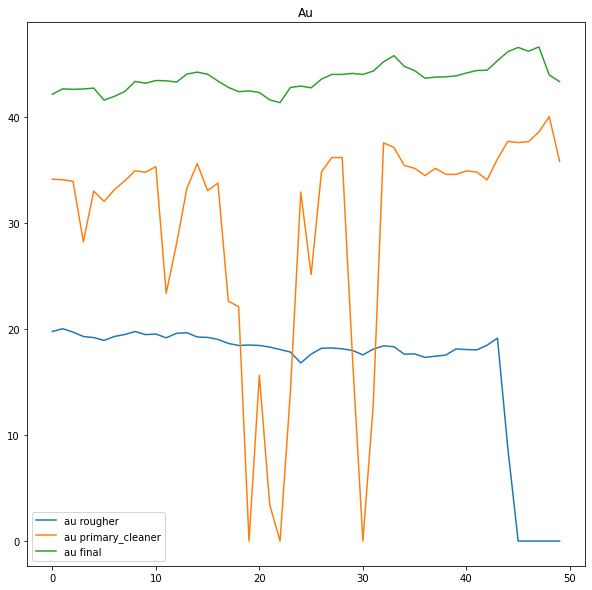

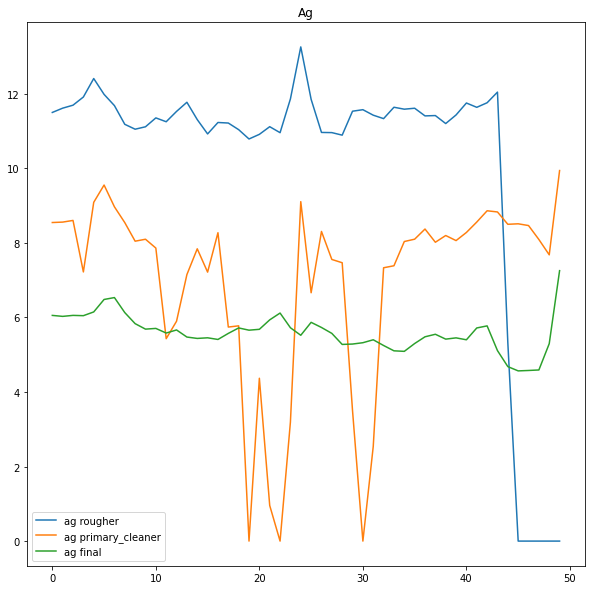

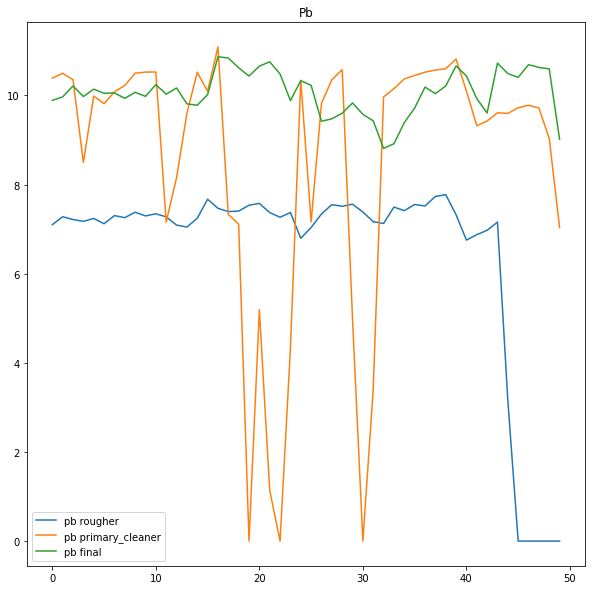

In [25]:
hours = 50
figsize = (10,10)

plt.figure(figsize=figsize)

plt.plot(df_train['rougher.output.concentrate_au'][:hours], label='au rougher')
plt.plot(df_train['primary_cleaner.output.concentrate_au'][:hours], label='au primary_cleaner')
plt.plot(df_train['final.output.concentrate_au'][:hours], label='au final')

legend = plt.legend(loc='lower left', shadow=False, fontsize='medium')
plt.title('Au')

plt.show()


plt.figure(figsize=figsize)

plt.plot(df_train['rougher.output.concentrate_ag'][:hours], label='ag rougher')
plt.plot(df_train['primary_cleaner.output.concentrate_ag'][:hours], label='ag primary_cleaner')
plt.plot(df_train['final.output.concentrate_ag'][:hours], label='ag final')

legend = plt.legend(loc='lower left', shadow=False, fontsize='medium')
plt.title('Ag')

plt.show()


plt.figure(figsize=figsize)

plt.plot(df_train['rougher.output.concentrate_pb'][:hours], label='pb rougher')
plt.plot(df_train['primary_cleaner.output.concentrate_pb'][:hours], label='pb primary_cleaner')
plt.plot(df_train['final.output.concentrate_pb'][:hours], label='pb final')

legend = plt.legend(loc='lower left', shadow=False, fontsize='medium')
plt.title('Pb')

plt.show()

### Conclusion

The concentration of gold increases with each stage of purification, which is logical.
<br> The concentration of silver decreases with each stage, which is also logical.
<br> But the concentration of lead is growing. This is probably due to the technological process of processing and lead is not yet removed at these stages.
<br> Abnormal values are also visible, which may be associated with the technological process.

## Comparison of the size distribution of raw material granules on the train and test samples

### Rougher

Let's check the equality of the mean of two general populations for their samples

In [26]:
results = st.ttest_ind(df_train['rougher.input.feed_size'].dropna(), df_test['rougher.input.feed_size'].dropna(), equal_var=False)
print('p-value:',results.pvalue)

p-значение: 6.7950959991986745e-15


The distributions in the primary_cleaner stage do not differ much from each other.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


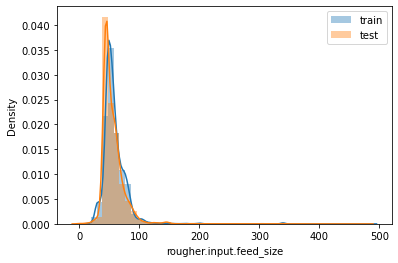

In [27]:
# hist_data = [df_train['rougher.input.feed_size'].dropna(), df_test['rougher.input.feed_size'].dropna()]
# group_labels = ['train', 'test']

# fig = ff.create_distplot(hist_data, group_labels, bin_size=0.2)
# fig.show()

sns.distplot(df_train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(df_test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

The distributions at the rougher stage do not differ much from each other.

### Primary_cleaner

Let's check the equality of the mean of two general populations for their samples

In [28]:
results = st.ttest_ind(df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size'], equal_var=False)
print('p-value:',results.pvalue)

p-значение: 0.0004554672200801049


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


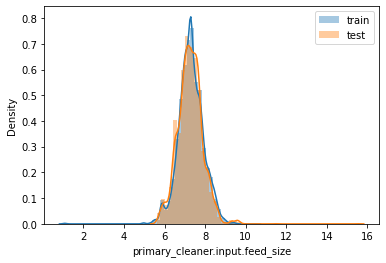

In [29]:
# hist_data = [df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size']]
# group_labels = ['train', 'test']

# fig = ff.create_distplot(hist_data, group_labels, bin_size=0.2)
# fig.show()

sns.distplot(df_train['primary_cleaner.input.feed_size'].dropna(), label='train')
sns.distplot(df_test['primary_cleaner.input.feed_size'].dropna(), label='test')
plt.legend()

The distributions in the primary_cleaner stage do not differ much from each other.

## Study of the total concentration of all substances at different stages: in raw materials, in roughing and final concentrates

### Raw

In [30]:
df_train['sum_rougher'] = df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_pb'] + \
                          df_train['rougher.output.concentrate_sol'] + df_train['rougher.output.concentrate_au']

df_train['sum_primary'] = df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_pb'] + \
                          df_train['primary_cleaner.output.concentrate_sol'] + df_train['primary_cleaner.output.concentrate_au']

df_train['sum_final'] = df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb'] + \
                        df_train['final.output.concentrate_sol'] + df_train['final.output.concentrate_au']

In [ ]:
hours = 200
figsize = (5,5)

plt.figure(figsize=figsize)

plt.plot(df_train['sum_rougher'][:hours], label='sum rougher')
plt.plot(df_train['sum_primary'][:hours], label='sum primary_cleaner')
plt.plot(df_train['sum_final'][:hours], label='sum final')

legend = plt.legend(loc='lower left', shadow=False, fontsize='small')
plt.title('Sum concentrations')

plt.show()

sns.displot(df_train['sum_rougher'], kde=True, height=5, aspect=1)
sns.displot(df_train['sum_primary'], kde=True, height=5, aspect=1)
sns.displot(df_train['sum_final'], kde=True, height=5, aspect=1)

The graphs show anomalous distributions in the total distribution.
<br> Probably, this is due to the technological process of processing.
<br> For example, anomalous values may appear due to maintenance.
<br> It is necessary to remove these anomalies, as they may affect the prediction of the model in the future.

Remove these anomalies

In [31]:
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                11017 non-null  object 
 1   final.output.concentrate_ag                         11017 non-null  float64
 2   final.output.concentrate_pb                         11017 non-null  float64
 3   final.output.concentrate_sol                        11017 non-null  float64
 4   final.output.concentrate_au                         11017 non-null  float64
 5   final.output.recovery                               11017 non-null  float64
 6   final.output.tail_ag                                11017 non-null  float64
 7   final.output.tail_pb                                11017 non-null  float64
 8   final.output.tail_sol                               11017 non-null  float64


We define functions for finding the upper and lower boundaries of the distribution

In [32]:
def bot_line(name):
    
    Q1 = df_train[name].quantile(0.25)
    Q3 = df_train[name].quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 3*IQR
    
    
def top_line(name):
    
    Q1 = df_train[name].quantile(0.25)
    Q3 = df_train[name].quantile(0.75)
    IQR = Q3 - Q1
    return Q3 + 3*IQR  

At the flotation stage

count    11017.000000
mean        67.898765
std         12.244650
min          0.000000
25%         65.471243
50%         69.701409
75%         73.921804
max         87.273435
Name: sum_rougher, dtype: float64



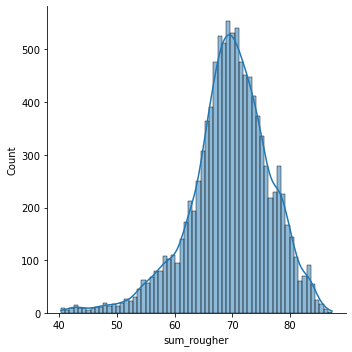

count    10710.000000
mean        69.551822
std          7.010853
min         40.295602
25%         65.917981
50%         69.922144
75%         74.086620
max         87.273435
Name: sum_rougher, dtype: float64



In [33]:
print(df_train['sum_rougher'].describe())
print()

index = df_train[(df_train['sum_rougher'] <= bot_line('sum_rougher')) | (df_train['sum_rougher'] >= top_line('sum_rougher'))].index
df_train = df_train.drop(index)
sns.displot(df_train['sum_rougher'], kde=True, height=5, aspect=1)
plt.show()

print(df_train['sum_rougher'].describe())
print()

During the first stage of cleaning

count    10710.000000
mean        60.803031
std          9.298766
min          0.000000
25%         58.608185
50%         61.974055
75%         65.500708
max         76.918076
Name: sum_primary, dtype: float64



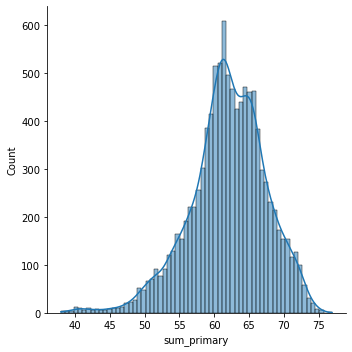

count    10447.000000
mean        61.941809
std          5.502051
min         37.983271
25%         58.931515
50%         62.117802
75%         65.590575
max         76.918076
Name: sum_primary, dtype: float64



In [34]:
print(df_train['sum_primary'].describe())
print()

index = df_train[(df_train['sum_primary'] <= bot_line('sum_primary')) | (df_train['sum_primary'] >= top_line('sum_primary'))].index
df_train = df_train.drop(index)
sns.displot(df_train['sum_primary'], kde=True, height=5, aspect=1)
plt.show()

print(df_train['sum_primary'].describe())
print()

At the final stage

count    10447.000000
mean        69.217177
std          5.517997
min          0.000000
25%         67.919297
50%         69.492120
75%         71.329002
max         80.210644
Name: sum_final, dtype: float64



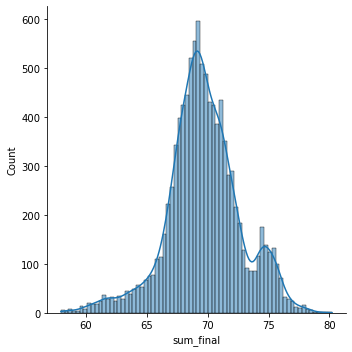

count    10312.000000
mean        69.671812
std          3.043355
min         57.957648
25%         67.984883
50%         69.536311
75%         71.360521
max         80.210644
Name: sum_final, dtype: float64



In [35]:
print(df_train['sum_final'].describe())
print()

index = df_train[(df_train['sum_final'] <= bot_line('sum_final')) | (df_train['sum_final'] >= top_line('sum_final'))].index
df_train = df_train.drop(index)
sns.displot(df_train['sum_final'], kde=True, height=5, aspect=1)
plt.show()

print(df_train['sum_final'].describe())
print()

As can be seen from the description of the graphs, the average has not changed much, but the distribution has become much better.

# Model building

## Preparing data for the model

It is necessary to prepare two datasets.
<br> The first to predict the share of gold after flotation.
<br> Second for predicting the share of gold after cleaning.

<br> Obviously, all the necessary NOT target features are contained in the train dataset.
<br> For the first dataset, you need to select features with the stage `rougher` and add the target feature `rougher.output.recovery`.
<br> For the second dataset, select all features and add the target feature `final.output.recovery`.

Variables with the index `_r` in the name will refer to the black concentrate, those having `_f`, respectively, to the final concentrate.

In [36]:
col_r = df_test.columns[13:23].to_list()
col_r.append('rougher.output.recovery')
col_r

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.recovery']

In [37]:
df_r = df_train[col_r]
df_r.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,87.107763
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,86.843261
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,86.842308
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,87.226430
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,86.688794


In [38]:
col_f = df_test.columns[1:].to_list()
col_f.append('final.output.recovery')
col_f

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

In [39]:
df_f = df_train[col_f]
df_f.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,70.541216
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,69.266198
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,68.116445
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,1600.449520,-500.052575,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.79

Let's divide the samples into sets with features and a target feature.

In [40]:
features_r = df_r.drop(['rougher.output.recovery'], axis=1)
target_r = df_r['rougher.output.recovery']

features_f = df_f.drop(['final.output.recovery'], axis=1)
target_f = df_f['final.output.recovery']

Let's divide each sample into two: train, validation in the ratio `3 : 1`.

In [41]:
features_train_r, features_valid_r = train_test_split(features_r, test_size=0.25, random_state=12345)
target_train_r, target_valid_r = train_test_split(target_r, test_size=0.25, random_state=12345)

print(features_r.shape)
print(features_train_r.shape)
print(features_valid_r.shape)
print(target_train_r.shape)
print(target_valid_r.shape)
print()


features_train_f, features_valid_f = train_test_split(features_f, test_size=0.25, random_state=12345)
target_train_f, target_valid_f = train_test_split(target_f, test_size=0.25, random_state=12345)

print(features_f.shape)
print(features_train_f.shape)
print(features_valid_f.shape)
print(target_train_f.shape)
print(target_valid_f.shape)
print()

(10312, 10)
(7734, 10)
(2578, 10)
(7734,)
(2578,)

(10312, 52)
(7734, 52)
(2578, 52)
(7734,)
(2578,)



Scale features

In [42]:
# Remove the target feature from the array with all features
num_r = col_r[:len(col_r)-1]
num_f = col_f[1:len(col_f)-1]


scaler_r = StandardScaler()
scaler_r.fit(features_train_r.loc[:, num_r])
features_train_r.loc[:, num_r] = scaler_r.transform(features_train_r.loc[:, num_r])
features_valid_r.loc[:, num_r] = scaler_r.transform(features_valid_r.loc[:, num_r])
features_r.loc[:, num_r] = scaler_r.transform(features_r.loc[:, num_r])

scaler_f = StandardScaler()
scaler_f.fit(features_train_f.loc[:, num_f])
features_train_f.loc[:, num_f] = scaler_f.transform(features_train_f.loc[:, num_f])
features_valid_f.loc[:, num_f] = scaler_f.transform(features_valid_f.loc[:, num_f])
features_f.loc[:, num_f] = scaler_f.transform(features_f.loc[:, num_f])

In [43]:
features_train_r.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate
14438,-1.176966,-1.662283,1.015747,0.341356,-0.015145,-1.895418,-1.790188,-0.075953,-1.781262,-0.082314
10122,-1.034018,-0.912342,0.254999,0.230995,-0.077911,-1.385055,1.308401,-0.371532,1.306470,-0.377474
14164,-0.024642,0.375605,1.461736,1.262687,0.740892,0.195249,-0.038007,1.476703,-0.033745,1.421279
13902,1.014281,-0.983756,-0.799398,0.027874,0.798973,-0.999825,-2.489568,1.732620,-2.476993,1.673072
11206,-1.371902,0.094114,1.359594,0.071195,1.668330,-0.593086,1.307641,-0.571574,1.307131,-0.570646


## Model training

Define a function for calculating the sMAPE metric

In [37]:
def sMAPE(target, predicted):
    
    part = 100 * abs(target - predicted) / ((abs(target) + abs(predicted)) / 2)
    full = part.sum() / len(target)
    return full

Define a function for calculating model metrics

In [38]:
def model_results(model, features, target):

    predicted = model.predict(features)
    predicted = pd.Series(predicted, index=target.index) 

    MAE = mean_absolute_error(target, predicted) ** 0.5
    sMAPE_val = sMAPE(target, predicted)
    
    return (MAE, sMAPE_val)

### Linear regression

#### Efficiency of crude concentrate enrichment

In [39]:
model_r = LinearRegression()
model_r.fit(features_train_r, target_train_r)

results = model_results(model_r, features_valid_r, target_valid_r)

print('Mean:', '{:,.2f}'.format(target_valid_r.mean()))
print("MAE_valid_r:", results[0])
print("sMAPE_valid_r:", results[1])
print()

results = model_results(model_r, features_r, target_r)

print('Mean:', '{:,.2f}'.format(target_r.mean()))
print("MAE_r:", results[0])
print("sMAPE_r:", results[1])
print()

Среднее значение: 84.39
MAE_valid_r: 1.984049190453059
sMAPE_valid_r: 4.783321145351461

Среднее значение: 84.28
MAE_r: 1.9908278480847013
sMAPE_r: 4.845851279890706



#### Final concentrate enrichment efficiency

In [40]:
model_f = LinearRegression()
model_f.fit(features_train_f, target_train_f)

results = model_results(model_f, features_valid_f, target_valid_f)

print('Mean:', '{:,.2f}'.format(target_valid_f.mean()))
print("MAE_valid_f:", results[0])
print("sMAPE_valid_f:", results[1])
print()

results = model_results(model_f, features_f, target_f)

print('Mean:', '{:,.2f}'.format(target_f.mean()))
print("MAE_f:", results[0])
print("sMAPE_r:", results[1])
print()

Среднее значение: 66.98
MAE_valid_f: 2.0822964361544716
sMAPE_valid_f: 6.706793284608502

Среднее значение: 66.98
MAE_f: 2.0750429136852357
sMAPE_r: 6.647836504707543



### Decision tree

#### Efficiency of crude concentrate enrichment

In [41]:
param_grid = {'max_depth': range(1,10)}

dtr_r = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345), param_grid=param_grid, cv=5)
dtr_r.fit(features_train_r, target_train_r)
dtr_r.best_params_

{'max_depth': 9}

In [42]:
results = model_results(dtr_r, features_valid_r, target_valid_r)

print('Mean:', '{:,.2f}'.format(target_valid_r.mean()))
print("MAE_valid_r:", results[0])
print("sMAPE_valid_r:", results[1])
print()

results = model_results(dtr_r, features_r, target_r)

print('Mean:', '{:,.2f}'.format(target_r.mean()))
print("MAE_r:", results[0])
print("sMAPE_r:", results[1])
print()

Среднее значение: 84.39
MAE_valid_r: 1.790037484120781
sMAPE_valid_r: 3.9562294592238096

Среднее значение: 84.28
MAE_r: 1.6507748849995354
sMAPE_r: 3.3573987676556727



#### Final concentrate enrichment efficiency

In [43]:
param_grid = {'max_depth': range(1,10)}

dtr_f = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345), param_grid=param_grid, cv=5)
dtr_f.fit(features_train_f, target_train_f)
dtr_f.best_params_

{'max_depth': 7}

In [44]:
results = model_results(dtr_f, features_valid_f, target_valid_f)

print('Mean:', '{:,.2f}'.format(target_valid_f.mean()))
print("MAE_valid_f:", results[0])
print("sMAPE_valid_f:", results[1])
print()

results = model_results(dtr_f, features_f, target_f)

print('Mean:', '{:,.2f}'.format(target_f.mean()))
print("MAE_f:", results[0])
print("sMAPE_r:", results[1])
print()

Среднее значение: 66.98
MAE_valid_f: 1.9977674225599635
sMAPE_valid_f: 6.190442140662561

Среднее значение: 66.98
MAE_f: 1.9124069286568626
sMAPE_r: 5.612656081752664



### Random Forest

#### Efficiency of crude concentrate enrichment

In [45]:
param_grid = {'n_estimators': range(1,10), 'max_depth': range(1,10)}

rfr_r = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid=param_grid, cv=5)
rfr_r.fit(features_train_r, target_train_r)
rfr_r.best_params_

{'max_depth': 9, 'n_estimators': 9}

In [46]:
results = model_results(rfr_r, features_valid_r, target_valid_r)

print('Mean:', '{:,.2f}'.format(target_valid_r.mean()))
print("MAE_valid_r:", results[0])
print("sMAPE_valid_r:", results[1])
print()

results = model_results(rfr_r, features_r, target_r)

print('Среднее значение:', '{:,.2f}'.format(target_r.mean()))
print("MAE_r:", results[0])
print("sMAPE_r:", results[1])
print()

Среднее значение: 84.39
MAE_valid_r: 1.7100114148968082
sMAPE_valid_r: 3.5954279792128605

Среднее значение: 84.28
MAE_r: 1.6064337547448897
sMAPE_r: 3.203553916479789



#### Final concentrate enrichment efficiency

In [47]:
param_grid = {'n_estimators': range(1,10), 'max_depth': range(1,10)}

rfr_f = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid=param_grid, cv=5)
rfr_f.fit(features_train_f, target_train_f)
rfr_f.best_params_

{'max_depth': 9, 'n_estimators': 9}

In [48]:
results = model_results(rfr_f, features_valid_f, target_valid_f)

print('Mean:', '{:,.2f}'.format(target_valid_f.mean()))
print("MAE_valid_r:", results[0])
print("sMAPE_valid_r:", results[1])
print()

results = model_results(rfr_f, features_f, target_f)

print('Mean:', '{:,.2f}'.format(target_f.mean()))
print("MAE_r:", results[0])
print("sMAPE_r:", results[1])
print()

Среднее значение: 66.98
MAE_valid_r: 1.893465827985253
sMAPE_valid_r: 5.5372129623470085

Среднее значение: 66.98
MAE_r: 1.7763036763553983
sMAPE_r: 4.856229722663864



## Checking models on a test set

### Preparing test data

Fill in the test sample with target features taken from the full sample.

In [49]:
df_test = df_test.merge(df_full[['date','rougher.output.recovery']], on='date', how='left')
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-

In [50]:
df_test = df_test.merge(df_full[['date','final.output.recovery']], on='date', how='left')
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.5

In [51]:
def recovery_r(df):
    
    """
    C — share of gold in concentrate after flotation/refining;
    F — share of gold in raw material/concentrate before flotation/refining;
    T — share of gold in final tailings after flotation/cleaning.
    """
    C = df['rougher.output.concentrate_au']
    F = df['rougher.input.feed_au']
    T = df['rougher.output.tail_au']
    
    return 100 * C * (F - T) / (F * (C - T))

In [52]:
def recovery_f(df):
    
    """
    C — share of gold in concentrate after flotation/refining;
    F — share of gold in raw material/concentrate before flotation/refining;
    T — share of gold in final tailings after flotation/cleaning.
    """
    C = df['final.output.concentrate_au']
    F = df['rougher.output.concentrate_au']
    T = df['secondary_cleaner.output.tail_au']
    
    return 100 * C * (F - T) / (F * (C - T))

Let's divide the test sample into one that will relate to the draft concentrate and one that will relate to the final concentrate.

In [53]:
df_test.dropna(inplace=True)

df_test_r = df_test[col_r]
df_test_f = df_test[col_f]

Let's divide the sample into sets with features and a target feature.

In [54]:
features_test_r = df_test_r.drop(['rougher.output.recovery'], axis=1)
target_test_r = df_test_r['rougher.output.recovery']

features_test_f = df_test_f.drop(['final.output.recovery'], axis=1)
target_test_f = df_test_f['final.output.recovery']

Scale features

In [55]:
features_test_r.loc[:, num_r] = scaler_r.transform(features_test_r.loc[:, num_r])

features_test_f.loc[:, num_f] = scaler_f.transform(features_test_f.loc[:, num_f])

### Checking models on a test dataset

#### Linear Regression

In [56]:
Total = 0

results = model_results(model_r, features_test_r, target_test_r)
Total += 0.25*results[1]

print('Mean:', '{:,.2f}'.format(target_test_r.mean()))
print("MAE_test_r:", results[0])
print("sMAPE_test_r:", results[1])
print()

results = model_results(model_f, features_test_f, target_test_f)
Total += 0.75*results[1]

print('Mean:', '{:,.2f}'.format(target_test_f.mean()))
print("MAE_test_f:", results[0])
print("sMAPE_test_f:", results[1])
print()

print('Total sMAPE:', Total)

Среднее значение: 85.13
MAE_test_r: 2.273640117966432
sMAPE_test_r: 8.00513299467219

Среднее значение: 68.66
MAE_test_f: 2.3623466035916505
sMAPE_test_f: 8.848930385110208

Total sMAPE: 8.637981037500703


#### Decision tree

In [57]:
Total = 0

results = model_results(dtr_r, features_test_r, target_test_r)
Total += 0.25*results[1]

print('Mean:', '{:,.2f}'.format(target_test_r.mean()))
print("MAE_test_r:", results[0])
print("sMAPE_test_r:", results[1])
print()

results = model_results(dtr_f, features_test_f, target_test_f)
Total += 0.75*results[1]

print('Mean:', '{:,.2f}'.format(target_test_f.mean()))
print("MAE_test_f:", results[0])
print("sMAPE_test_f:", results[1])
print()

print('Total sMAPE:', Total)

Среднее значение: 85.13
MAE_test_r: 2.5070116236158735
sMAPE_test_r: 9.40237049460656

Среднее значение: 68.66
MAE_test_f: 2.475382628519077
sMAPE_test_f: 9.764230598286789

Total sMAPE: 9.673765572366731


#### Random Forest

In [58]:
Total = 0

results = model_results(rfr_r, features_test_r, target_test_r)
Total += 0.25*results[1]

print('Mean:', '{:,.2f}'.format(target_test_r.mean()))
print("MAE_test_r:", results[0])
print("sMAPE_test_r:", results[1])
print()

results = model_results(rfr_f, features_test_f, target_test_f)
Total += 0.75*results[1]

print('Mean:', '{:,.2f}'.format(target_test_f.mean()))
print("MAE_test_f:", results[0])
print("sMAPE_test_f:", results[1])
print()

print('Total sMAPE:', Total)

Среднее значение: 85.13
MAE_test_r: 2.33482147836425
sMAPE_test_r: 8.343812540151823

Среднее значение: 68.66
MAE_test_f: 2.5258775677238803
sMAPE_test_f: 10.116535898357249

Total sMAPE: 9.673355058805893


# Conclusion

The best result on the test dataset was shown by the linear regression model.
<br> Forecast accuracy of 8.64% is quite good.